# Mapping Interconnections: Conspiracies Behind Wildfire Causes in Portugal (part 3 - Visual analysis)

Carregar o CSV

In [1]:
import pandas as pd

# Carregar o CSV com conteúdos
df_artigos = pd.read_csv('detalhes_artigos_completo.csv')

df_artigos

,termo,site,ano,titulo,data,link,contents
0,incêndio,www.publico.pt,2017,Incêndio em Gaia - PÚBLICO,2017-01-18 04:36:37,https://arquivo.pt/noFrame/replay/201701180436...,('cookies cookies porpaulo pimenta 25 10 2016 ...
1,incêndio,www.publico.pt,2017,Complexo turístico Zmar recupera as infra-estr...,2017-01-10 20:21:26,https://arquivo.pt/noFrame/replay/201701102021...,('obras recuperacao edificios infra estruturas...
2,incêndio,www.publico.pt,2017,Zambujeira do Mar - PÚBLICO,2017-01-11 02:26:52,https://arquivo.pt/noFrame/replay/201701110226...,('cookies cookies todos porcarlos dias 10 01 2...
3,incêndio,www.publico.pt,2017,Ferreira do Zêzere - PÚBLICO,2017-01-11 06:05:20,https://arquivo.pt/noFrame/replay/201701110605...,('cookies esti utilizazo cookies localizazo to...
4,incêndio,www.publico.pt,2017,Andrzej Zulawski (1940 - 2016) - PÚBLICO,2017-06-22 05:00:38,https://arquivo.pt/noFrame/replay/201706220500...,('cookies cookies todos porluis miguel queiros...
...,...,...,...,...,...,...,...
522,seca,www.cmjornal.pt,2018,Vocalista dos Xutos surpreendido com homenagem...,2018-02-06 08:11:35,https://arquivo.pt/noFrame/replay/201802060811...,('tim vocalista banda portuguesa xutos pontape...
523,seca,www.cmjornal.pt,2018,Coro canta ‘Xutos & Pontapés’ e recorda Zé Ped...,2018-02-02 22:52:34,https://arquivo.pt/noFrame/replay/201802022252...,('nao unico olhar ceu cantam xutos pontapes do...
524,seca,www.cmjornal.pt,2018,Apple acaba com iPhone X já este verão - Tecno...,2018-02-07 03:30:17,https://arquivo.pt/noFrame/replay/201802070330...,('pensar comprar iphone x entao pense melhor a...
525,seca,www.cmjornal.pt,2018,Shawn Mendes atua no festival Sudoeste na Zamb...,2018-02-06 23:30:27,https://arquivo.pt/noFrame/replay/201802062330...,('pub pub pub pub copyright 2018 todos direito...


### 1. Sentiment analysis

In [3]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Baixando os recursos necessários do NLTK
nltk.download('vader_lexicon')

# Criando o analisador de sentimentos
analyzer = SentimentIntensityAnalyzer()

# Exemplo de texto para análise
text = "A mina causou um incêndio devastador."

# Analisando o sentimento
sentiment = analyzer.polarity_scores(text)

# Exibindo o resultado
print(sentiment)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Bernardo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


2min32s

In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Adicionando VADER
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from matplotlib_venn import venn2, venn3

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')  # Baixe o léxico do VADER

# Carregar o CSV original
df_artigos = pd.read_csv('detalhes_artigos_liquidos.csv')

# Adicionar colunas para o conteúdo e sentimentos
df_artigos['contents'] = None
df_artigos['sentiment_compound'] = None  # Score composto do VADER
df_artigos['sentiment_pos'] = None       # Proporção positiva
df_artigos['sentiment_neu'] = None       # Proporção neutra
df_artigos['sentiment_neg'] = None       # Proporção negativa

# Função para limpar o texto
def clean_text(text):
    unwanted_phrases = [
        r"pague assinatura", r"aceite as cookies", r"ad block", r"publicidade", r"cookies", r"aceitar cookies", r"todos"
    ]
    for phrase in unwanted_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    
    stop_words = set(stopwords.words('portuguese'))
    word_tokens = word_tokenize(text.lower())
    filtered_text = [word for word in word_tokens if word not in stop_words and word.isalpha()]
    cleaned_text = TreebankWordDetokenizer().detokenize(filtered_text)
    return cleaned_text.strip()

# Função para fazer scraping e limpar o artigo
def scrape_and_clean_article(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extrair o conteúdo do artigo
        content_div = soup.find('div', {'class': 'story__body'})
        if content_div:
            content = "\n".join([p.get_text(strip=True) for p in content_div.find_all('p')])
        else:
            content = "\n".join([p.get_text(strip=True) for p in soup.find_all('p')])

        # Limpar o conteúdo
        cleaned_content = clean_text(content)
        return cleaned_content
    except Exception as e:
        print(f"Erro ao processar {url}: {e}")
        return None

# Inicializando o analisador de sentimentos do VADER
analyzer = SentimentIntensityAnalyzer()

# Iterar sobre os links e fazer o scraping, limpeza e análise de sentimentos
for index, row in df_artigos.iterrows():
    url = row['link']
    cleaned_content = scrape_and_clean_article(url)
    if cleaned_content:
        df_artigos.at[index, 'contents'] = cleaned_content

        # Análise de sentimentos
        sentiment = analyzer.polarity_scores(cleaned_content)
        df_artigos.at[index, 'sentiment_compound'] = sentiment['compound']
        df_artigos.at[index, 'sentiment_pos'] = sentiment['pos']
        df_artigos.at[index, 'sentiment_neu'] = sentiment['neu']
        df_artigos.at[index, 'sentiment_neg'] = sentiment['neg']

# Salvar os resultados em um CSV
df_artigos.to_csv('detalhes_artigos_completo_com_sentimentos.csv', index=False)

print("Web scraping, limpeza e análise de sentimentos concluídos!")
print("Dados guardados em 'detalhes_artigos_completo_com_sentimentos.csv'.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bernardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bernardo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Bernardo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Erro ao processar https://arquivo.pt/noFrame/replay/20170815152855/http://www.sapo.pt/noticias/controlado-incendio-em-torre-residencial-no_598431e25e28b30728870262: 404 Client Error: Not Found for url: https://arquivo.pt/noFrame/replay/20170815152855/http://24.sapo.pt/noticias/internacional/artigo/controlado-incendio-em-torre-residencial-no-dubai_22757989.html
Web scraping, limpeza e análise de sentimentos concluídos!
Dados guardados em 'detalhes_artigos_completo_com_sentimentos.csv'.


2min25s

In [5]:
# Definir palavras-chave relacionadas ao contexto
keywords_positive = ['controlado', 'rápido', 'contido', 'salvo', 'resolvido']
keywords_negative = ['descontrolado', 'desastre', 'devastador', 'caos', 'grave']

# Iterar sobre os artigos
for index, row in df_artigos.iterrows():
    url = row['link']
    cleaned_content = scrape_and_clean_article(url)
    if cleaned_content:
        df_artigos.at[index, 'contents'] = cleaned_content

        # Análise de sentimentos com VADER
        sentiment = analyzer.polarity_scores(cleaned_content)
        df_artigos.at[index, 'sentiment_compound'] = sentiment['compound']
        df_artigos.at[index, 'sentiment_pos'] = sentiment['pos']
        df_artigos.at[index, 'sentiment_neu'] = sentiment['neu']
        df_artigos.at[index, 'sentiment_neg'] = sentiment['neg']

        # Contextualizar o sentimento
        if any(word in cleaned_content.lower() for word in keywords_positive):
            df_artigos.at[index, 'sentiment_context'] = 'Positivo'
        elif any(word in cleaned_content.lower() for word in keywords_negative):
            df_artigos.at[index, 'sentiment_context'] = 'Negativo'
        else:
            # Baseado no score composto do VADER como fallback
            if sentiment['compound'] >= 0.05:
                df_artigos.at[index, 'sentiment_context'] = 'Positivo'
            elif sentiment['compound'] <= -0.05:
                df_artigos.at[index, 'sentiment_context'] = 'Negativo'
            else:
                df_artigos.at[index, 'sentiment_context'] = 'Neutro'

Erro ao processar https://arquivo.pt/noFrame/replay/20170815152855/http://www.sapo.pt/noticias/controlado-incendio-em-torre-residencial-no_598431e25e28b30728870262: 404 Client Error: Not Found for url: https://arquivo.pt/noFrame/replay/20170815152855/http://24.sapo.pt/noticias/internacional/artigo/controlado-incendio-em-torre-residencial-no-dubai_22757989.html


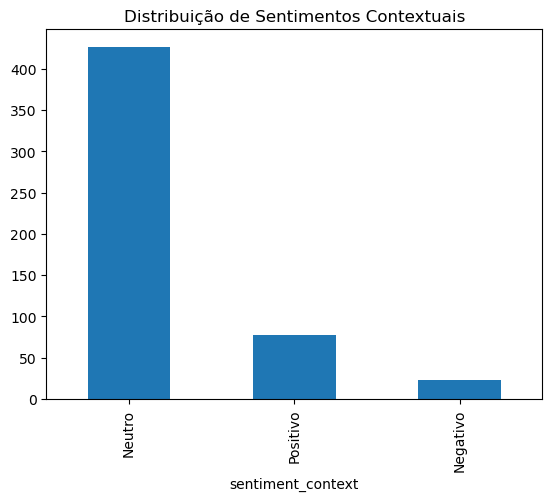

In [6]:
df_artigos['sentiment_context'].value_counts().plot(kind='bar')
plt.title('Distribuição de Sentimentos Contextuais')
plt.show()

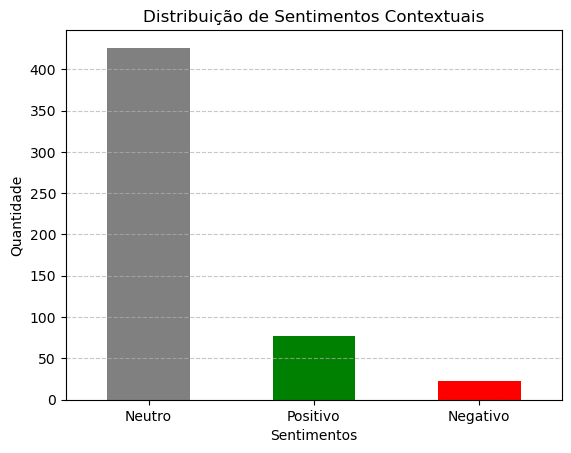

In [7]:
# Contar os valores de cada sentimento
sentiment_counts = df_artigos['sentiment_context'].value_counts()

# Definir cores para cada categoria
colors = {'Positivo': 'green', 'Negativo': 'red', 'Neutro': 'gray'}

# Criar o gráfico de barras com cores personalizadas
sentiment_counts.plot(kind='bar', color=[colors[label] for label in sentiment_counts.index])

# Personalizar o gráfico
plt.title('Distribuição de Sentimentos Contextuais')
plt.xlabel('Sentimentos')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)  # Mantém os rótulos horizontais
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adiciona uma grade ao eixo Y
plt.show()

### 2. Rede de interconexcões

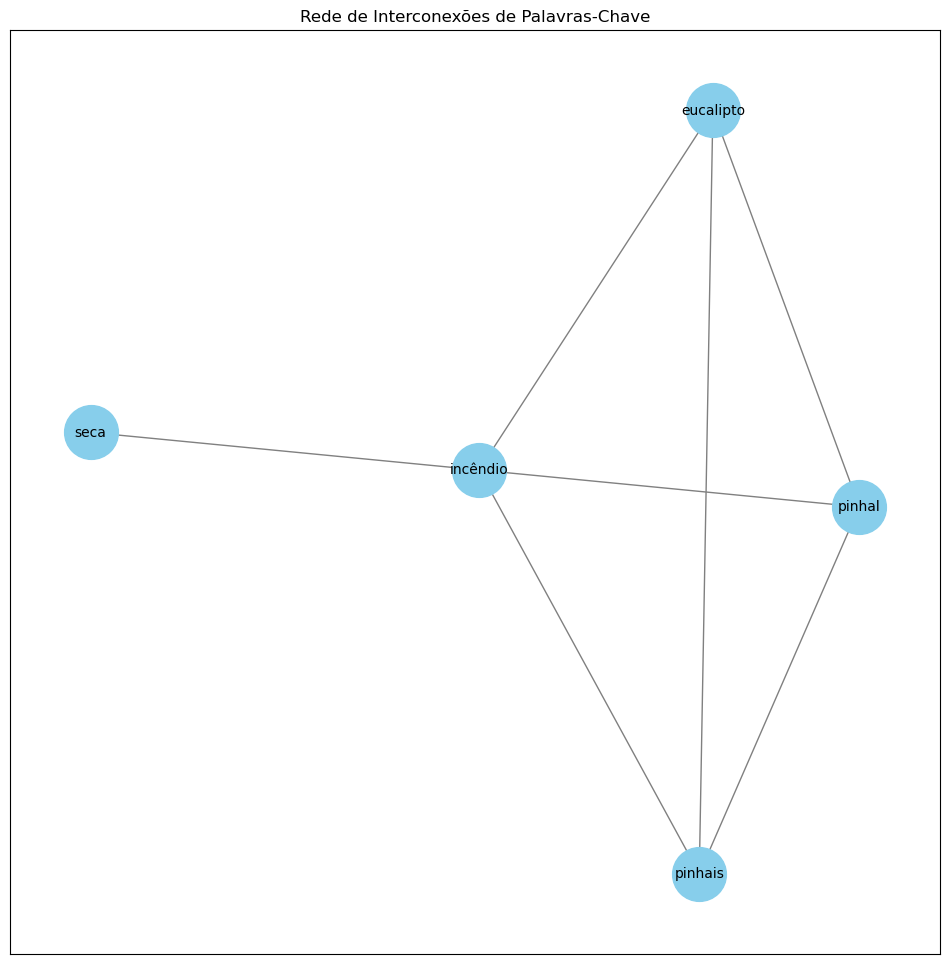

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Lista de palavras-chave
keywords_list = [
    "incêndio", "queimada", "fogo florestal", "mina", "indústria papel",
    "exploração de lítio", "fogo posto", "eucalipto", "pinhal", "pinhais",
    "limpeza florestal", "calor extremo", "vento forte", "seca"
]

# Criar grafo
G = nx.Graph()

# Adicionar arestas com base nas palavras-chave
for index, row in df_artigos.iterrows():
    # Verificar se a coluna 'contents' não é None antes de processar
    if row['contents'] is not None:
        # Obter palavras presentes no artigo que estão na lista de palavras-chave
        keywords_in_article = set(row['contents'].split()) & set(keywords_list)
        # Adicionar arestas para cada par de palavras-chave no mesmo artigo
        for kw1 in keywords_in_article:
            for kw2 in keywords_in_article:
                if kw1 != kw2:
                    G.add_edge(kw1, kw2)

# Visualizar o grafo
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    G,
    with_labels=True,
    node_color='skyblue',
    edge_color='grey',
    node_size=1500,
    font_size=10,
)
plt.title('Rede de Interconexões de Palavras-Chave')
plt.show()


3. Heatmap

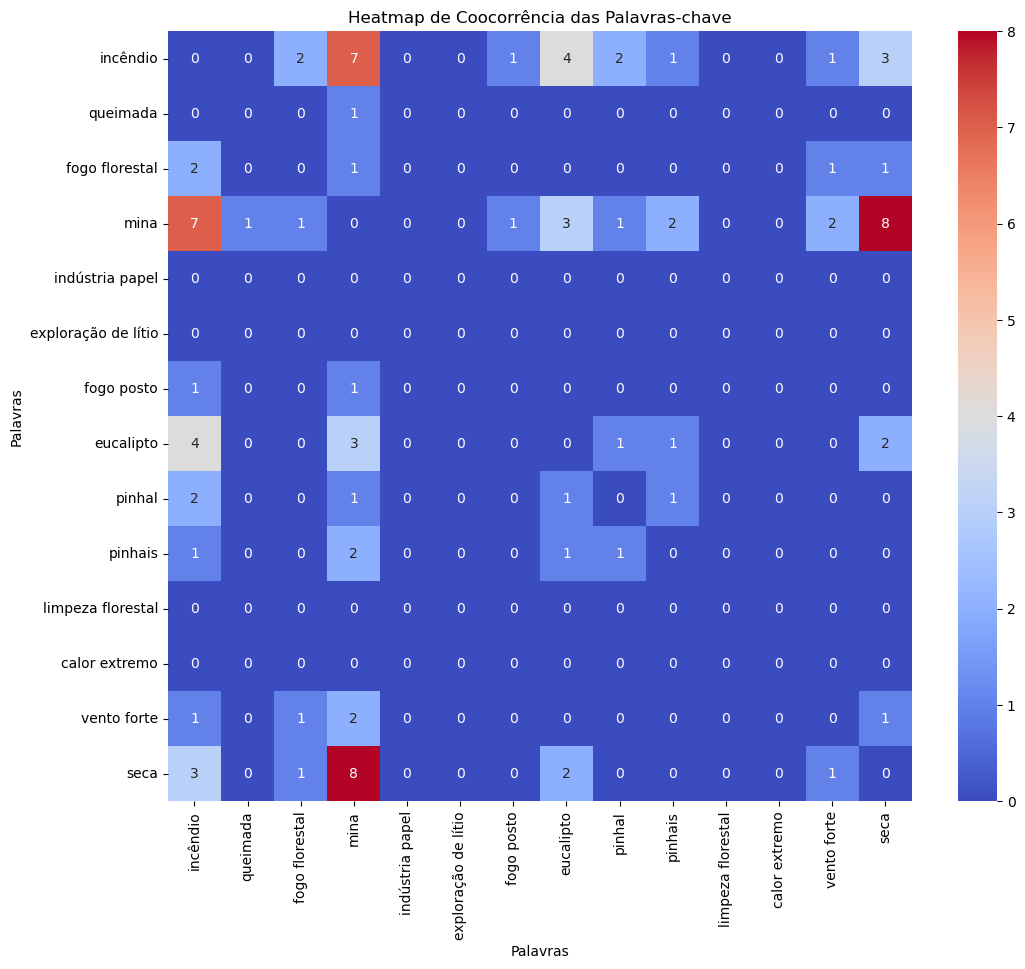

In [9]:
# Updated list of keywords
palavras_chave = [
    "incêndio", "queimada", "fogo florestal", "mina", "indústria papel", "exploração de lítio", 
    "fogo posto", "eucalipto", "pinhal", "pinhais", "limpeza florestal", "calor extremo", "vento forte", "seca"
]

# Function to find keywords in the content
def encontrar_palavras_chave(conteudo, palavras):
    if conteudo:
        tokens = conteudo.lower()
        return {palavra for palavra in palavras if palavra in tokens}
    return set()

# Apply keyword search to the DataFrame
df_artigos['keywords'] = df_artigos['contents'].apply(lambda x: encontrar_palavras_chave(x, palavras_chave))

# Create sets for each keyword
sets = {palavra: set() for palavra in palavras_chave}
for index, row in df_artigos.iterrows():
    for palavra in row['keywords']:
        sets[palavra].add(index)

# Create the co-occurrence matrix
coocorrencia = pd.DataFrame(0, index=palavras_chave, columns=palavras_chave)
for palavra1 in palavras_chave:
    for palavra2 in palavras_chave:
        if palavra1 != palavra2:
            coocorrencia.at[palavra1, palavra2] = len(sets[palavra1].intersection(sets[palavra2]))

# Block for plotting the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(coocorrencia, annot=True, cmap="coolwarm", fmt="d", cbar=True)
plt.title("Heatmap de Coocorrência das Palavras-chave")
plt.xlabel("Palavras")
plt.ylabel("Palavras")
plt.show()


4. Venn diagrams

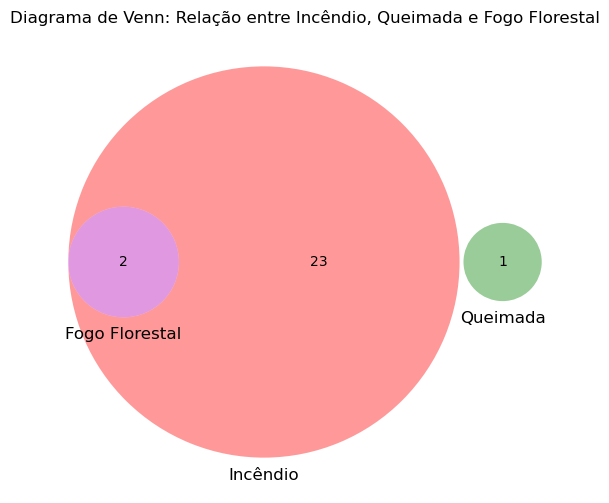

In [10]:
# Block for Venn diagram with three keywords (example: "incêndio", "queimada", "fogo florestal")
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn3([sets["incêndio"], sets["queimada"], sets["fogo florestal"]],
      set_labels=("Incêndio", "Queimada", "Fogo Florestal"))
plt.title("Diagrama de Venn: Relação entre Incêndio, Queimada e Fogo Florestal")
plt.show()


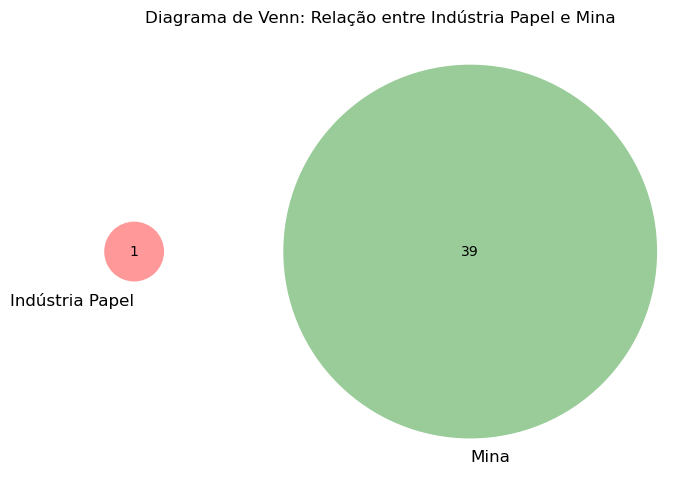

In [11]:
# Block for Venn diagram with two keywords (example: "indústria papel" and "mina")
from matplotlib_venn import venn2

plt.figure(figsize=(8, 6))
venn2([sets["indústria papel"], sets["mina"]], set_labels=("Indústria Papel", "Mina"))
plt.title("Diagrama de Venn: Relação entre Indústria Papel e Mina")
plt.show()
